In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/icb/dominik.klein/miniconda3/envs/moscot_with_cupti_gpu_fix/lib/python3.8/site-packages/docrep/decorators.py:43: SyntaxWarning: 'CompoundBaseProblem_push.raises' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/icb/dominik.klein/miniconda3/envs/moscot_with_cupti_gpu_fix/lib/python3.8/site-packages/docrep/decorators.py:43: SyntaxWarning: 'CompoundBaseProblem_pull.raises' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
# this is still without poiss_atac space, update the path!
adata = sc.read_h5ad("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_with_multi_VI_embedding.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 16978 × 166082
    obs: 'batch_id', 'modality', '_scvi_batch', 'celltype'
    var: 'n_cells', 'feature_type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'multi_vi', 'umap'
    obsm: 'X_multi_vi', 'multi_vi_umap'
    layers: 'counts'
    obsp: 'multi_vi_connectivities', 'multi_vi_distances'

In [4]:
adata.obs['time'] = adata.obs.apply(lambda x: 0 if x["sample"]=="E14-5" else 1, axis=1)

KeyError: 'sample'

# PCA on ATAC space

In [5]:
#sc.pp.pca(adata)

In [ ]:
adata

In [6]:
# this takes a while because PCA is computed internally
tp0 = TemporalProblem(adata)
#tp0.score_genes_for_marginals(gene_set_proliferation="mouse", gene_set_apoptosis="mouse")
tp0 = tp0.prepare("time", joint_attr="X_")

In [ ]:
tp0 = tp0.solve(epsilon=5e-2, scale_cost="mean", tau_a=0.8, tau_b=0.95, max_iterations=1e5)

In [ ]:
ct_desc = tp0.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants")
plt.show()

In [46]:
ct_anc = tp0.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=False)

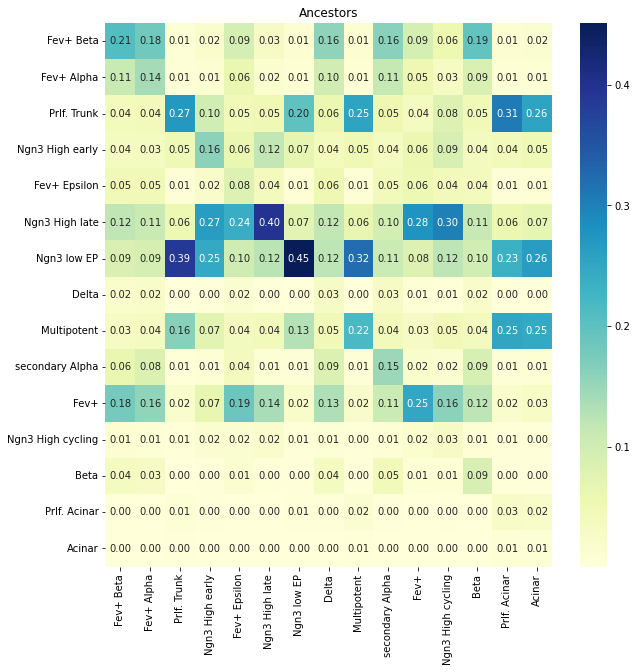

In [47]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors")
plt.show()

# PCA on ATAC space

In [111]:
adata_atac = adata[:, adata.var["feature_type"]=="ATAC"].copy()
adata_atac.obsm["X_pca"] = adata.obsm["ATAC_pca"].copy()
adata_atac.obsm["X_umap"] = adata.obsm["ATAC_umap"].copy()

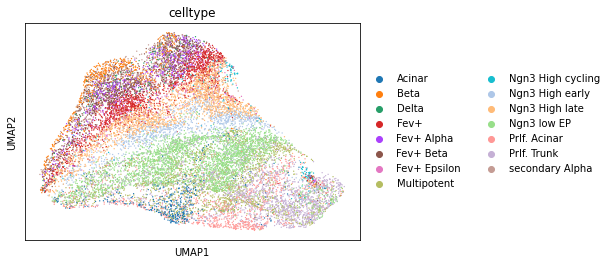

In [112]:
sc.pl.umap(adata_atac, color="celltype")

In [113]:
tp1 = TemporalProblem(adata_gex)
tp1 = tp1.prepare("time", joint_attr="ATAC_pca")

In [114]:
tp1 = tp1.solve(epsilon=1e-3, scale_cost="mean", tau_a=1, tau_b=1)

/mnt/home/icb/dominik.klein/git_repos/moscot/moscot/solvers/_base_solver.py:211: UserWarning: Solver did not converge
  warnings.warn("Solver did not converge")
/mnt/home/icb/dominik.klein/git_repos/moscot/moscot/solvers/_utils.py:26: UserWarning: Source marginals are not satisfied within rtol=1.0150223304912707e-05, atol=1.0150223304912707e-05.
  warnings.warn(msg)
/mnt/home/icb/dominik.klein/git_repos/moscot/moscot/solvers/_utils.py:26: UserWarning: Target marginals are not satisfied within rtol=1.4033118158854897e-05, atol=1.4033118158854897e-05.
  warnings.warn(msg)


In [115]:
ct_desc = tp1.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=True)

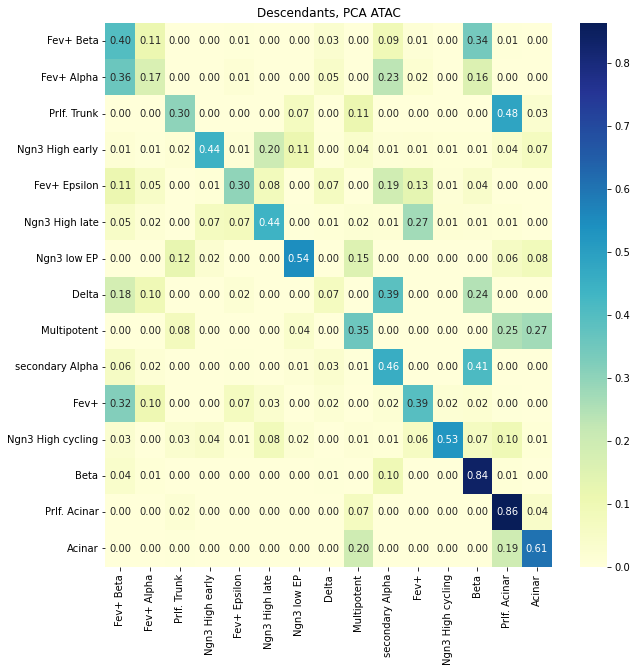

In [116]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants, PCA ATAC")
plt.show()

In [117]:
ct_anc = tp1.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=False)

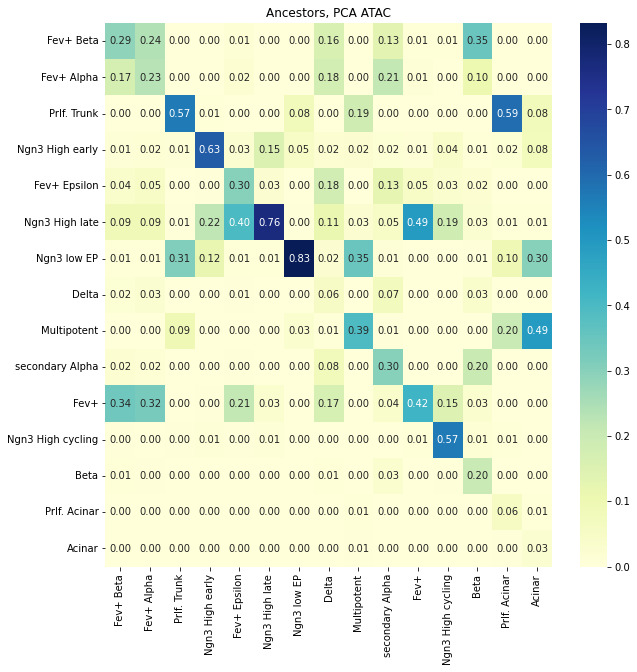

In [118]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors, PCA ATAC")
plt.show()

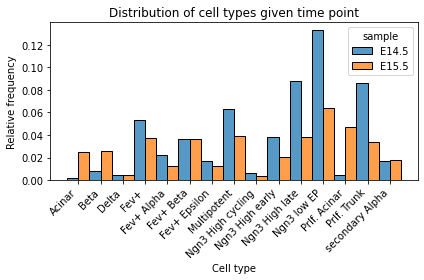

In [63]:
sns.histplot(data=adata_atac.obs, x="celltype", hue="sample", multiple='dodge', stat = 'probability')
plt.xlabel("Cell type")
plt.ylabel("Relative frequency")
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of cell types given time point")
plt.tight_layout()

# PCA on GEX + PCA on ATAC space

In [92]:
from sklearn.metrics import pairwise_distances
import numpy as np

In [85]:
adata.obsm["GEX_pca"].std(), adata.obsm["ATAC_pca"].std()

(1.8982601, 15.407883)

In [90]:
gex_pca_tr = StandardScaler().fit_transform(adata.obsm["GEX_pca"])
atac_pca_tr = StandardScaler().fit_transform(adata.obsm["ATAC_pca"])

In [93]:
adata.obsm["joint_PCA"] = np.concatenate((gex_pca_tr, atac_pca_tr), axis=1)

In [79]:
C_gex = pairwise_distances(adata_gex[adata_gex.obs["time"]==0].obsm["X_pca"], adata_gex[adata_gex.obs["time"]==1].obsm["X_pca"], metric="sqeuclidean")
C_atac = pairwise_distances(adata_atac[adata_atac.obs["time"]==0].obsm["X_pca"], adata_atac[adata_atac.obs["time"]==1].obsm["X_pca"], metric="sqeuclidean")

In [119]:
tp2 = TemporalProblem(adata)
tp2 = tp2.prepare("time", joint_attr="joint_PCA")

In [120]:
tp2 = tp2.solve(epsilon=1e-3, scale_cost="mean", tau_a=1, tau_b=1)

In [121]:
ct_desc = tp2.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=True)

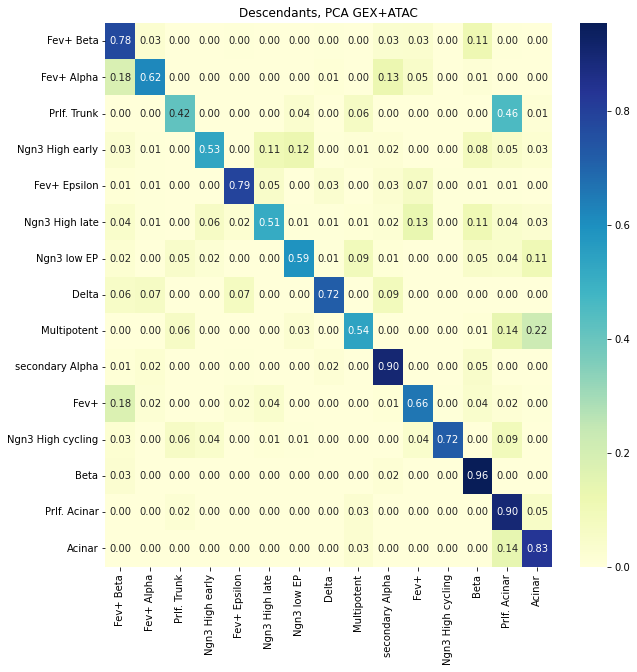

In [122]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_desc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Descendants, PCA GEX+ATAC")
plt.show()

In [103]:
ct_anc = tp2.cell_transition(early_cells="celltype", late_cells="celltype", start=0, end=1, forward=False)

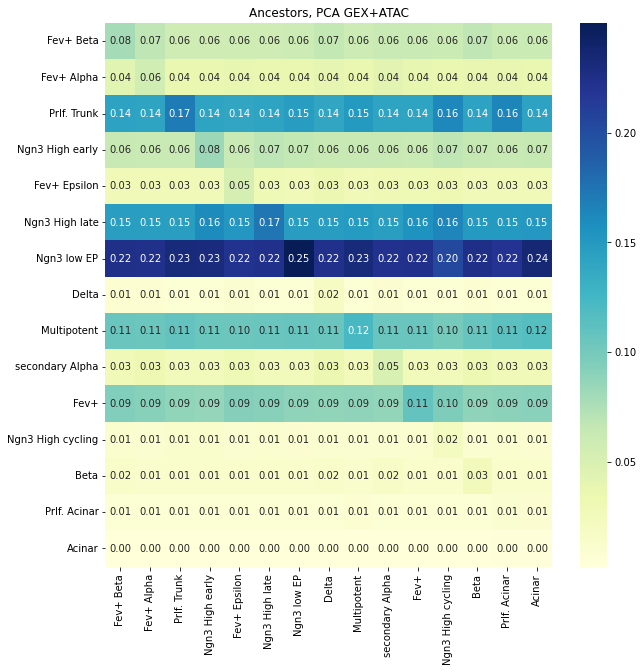

In [105]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(ct_anc, annot=True, cmap="YlGnBu", ax=ax, fmt=".2f", annot_kws={"fontsize": 10})
plt.title("Ancestors, PCA GEX+ATAC")
plt.show()

In [107]:
tp.cell_costs_source

,cell_cost_source
AAACAGCCAACAGCCT-1-0,-0.101696
AAACAGCCAACCCTCC-1-0,0.454478
AAACAGCCACCTGTAA-1-0,0.584158
AAACAGCCACTAAGCC-1-0,-0.144692
AAACAGCCAGGATAAC-1-0,-0.429829
...,...
TTTGTGTTCTTGTTCG-1-1,NaN
TTTGTTGGTATTGAGT-1-1,NaN
TTTGTTGGTCCTAAGA-1-1,NaN
TTTGTTGGTTAACAGT-1-1,NaN


In [108]:
sc.pl.umap(adata_gex, color=tp.cell_costs_source)

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: ['ATAC_pca', 'ATAC_umap', 'GEX_pca', 'GEX_umap', 'X_pca']."

In [110]:
adata_gex

AnnData object with n_obs × n_vars = 16978 × 228321
    obs: 'n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs', 'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores', 'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets', 'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values', 'dd_doublets_cat', 'pANN', 'DF_classifications_1', 'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1', 'DF_SCT_classifications_2', 'df_doublets'